# Machine learning model LaQuiniela

In this notebook we are going to develop a machine learning model to predict the matches results of LaLiga: (1) home, (2) visitor, (X) tie.

First of all, we import all the libraries we are going to use. 
The library `sqlite3` is for reading the files `.sqlite`, in particular, `laliga.sqlite`, with the information of the matches, and `classification.sqlite`, where we have store the data from exercise 10.

The library `sklearn` is for the machine learning model. The variable which will be predicted is discrete, so we have to develop a clasification model. To do that we have selected the `RandomForestClassifier`. The other functions of this library will help us to mesure the fitness of our model.

We have also add a new variable, `DATABASE_PATH_1`, to the file `settings.py`, to get the dataframe from exercise 10 with the clssification of each team.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import sys
sys.path.append('/home/la-quiniela-main/') # modify this if neccesary
import settings
import argparse
from settings import DATABASE_PATH, DATABASE_PATH_1
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

Secondly, we have define every function to clean and merge our two dataframes, matches (laliga) and classification, to get the training data and the test data for our model. 

The first four functions are from the file `io.py` to load the dataframes.

In [2]:
def load_matchday_laliga(season, division, matchday):
    with sqlite3.connect(DATABASE_PATH) as conn:
        data = pd.read_sql(f"""
            SELECT * FROM Matches
                WHERE season = '{season}'
                  AND division = {division}
                  AND matchday = {matchday}
        """, conn)
    if data.empty:
        raise ValueError("There is no matchday data for the values given")
    return data

def load_matchday_classification(season, division, matchday):
    with sqlite3.connect(DATABASE_PATH_1) as conn:
        data = pd.read_sql(f"""
            SELECT * FROM classification
                WHERE season = '{season}'
                  AND division = {division}
                  AND matchday = {matchday}
        """, conn)
    if data.empty:
        raise ValueError("There is no matchday data for the values given")
    return data

def load_historical_data_laliga(seasons):
    with sqlite3.connect(DATABASE_PATH) as conn:
        if seasons == "all":
            data = pd.read_sql("SELECT * FROM Matches", conn)
        else:
            data = pd.read_sql(f"""
                SELECT * FROM Matches
                    WHERE season IN {tuple(seasons)}
            """, conn)
    if data.empty:
        raise ValueError(f"No data for seasons {seasons}")
    return data

def load_historical_data_classification(seasons):
    with sqlite3.connect(DATABASE_PATH_1) as conn:
        if seasons == "all":
            data = pd.read_sql("SELECT * FROM classification", conn)
        else:
            data = pd.read_sql(f"""
                SELECT * FROM classification
                    WHERE season IN {tuple(seasons)}
            """, conn)
    if data.empty:
        raise ValueError(f"No data for seasons {seasons}")
    return data


The next function converts the value of the seasons to train, given in the terminal, in a list.

In [3]:
def parse_seasons(value):
    if value == "all":
        return "all"
    seasons = []
    for chunk in value.split(","):
        if ":" in chunk:
            try:
                start, end = map(int, chunk.split(":"))
                assert start < end
            except Exception:
                raise argparse.ArgumentTypeError(f"Unexpected format for seasons {value}")
            for i in range(start, end):
                seasons.append(f"{i}-{i+1}")
        else:
            try:
                start, end = map(int, chunk.split("-"))
                assert start == end - 1
            except Exception:
                raise argparse.ArgumentTypeError(f"Unexpected format for seasons {value}")
            seasons.append(chunk)
    return seasons

Te next one is to save the predictions of our model in the table `Predictions` inside the file `laliga.sqlite`, which is originally empty.

In [4]:
def save_predictions(predictions):
    predictions = predictions[["season", "division", "matchday", 
                               "date", "time", "home_team", 
                               "away_team", "score", "pred"]]
    with sqlite3.connect(DATABASE_PATH) as conn:
        predictions.to_sql(name="Predictions", con=conn, if_exists="append", index=False)

The function `add_result` adds a new column to the matches dataframe. This is going to be our target column, the one we want to predict.

In [5]:
def add_result(df):
    df2 = df.copy()
    df2["result"] = None
    df2.loc[(df2["score"].str.split(":").str[0]) > (df2["score"].str.split(":").str[1]), "result"] = '1'
    df2.loc[(df2["score"].str.split(":").str[0]) == (df2["score"].str.split(":").str[1]), "result"] = 'X'
    df2.loc[(df2["score"].str.split(":").str[0]) < (df2["score"].str.split(":").str[1]), "result"] = '2'
    
    df2.dropna(subset="score", inplace=True)
    return df2

The next two functions merge two dataframes. We are going to used them as follows: first we merge the dataframes matches and classification in a way that we obtain another dataframe, df, with the data of every match and the classification data of the home_team. Then we used the second function, to merge df with the classsification dataframe to obtain a final dataframe with the data of every match and the classification data of both teams, home_team and away_team.

In [6]:
def merge_and_clean_home(df_games, df_teams):
    df = pd.merge(df_games.copy(), df_teams.copy(), 
                             left_on=['home_team', "season", "division", "matchday"],
                             right_on=['team', "season", "division", "matchday"])
    df.drop("team", axis=1, inplace=True)

    return df

In [7]:
def merge_and_clean_visitor(df, df_teams):
    df2 = pd.merge(df.copy(), df_teams.copy(), 
                             left_on=['away_team', "season", "division", "matchday"],
                             right_on=['team', "season", "division", "matchday"],
                             suffixes=("_home", "_away"))
    df2.drop("team", axis=1, inplace=True)

    return df2

Finally, the last two functions create the dataframes we need to train and test our model.

In [8]:
def df_train(seasons):   
    classification = load_historical_data_classification(seasons)
    matches = load_historical_data_laliga(seasons)
    classification.dropna(subset="rank", inplace=True)
    matches = add_result(matches)
    
    df_train = merge_and_clean_home(matches, classification)
    df_train = merge_and_clean_visitor(df_train, classification)
    return df_train

In [9]:
def df_test(season, division, matchday):
    classification = load_matchday_classification(season, division, matchday)
    matches =load_matchday_laliga(season, division, matchday)
    classification.dropna(subset="rank", inplace=True)
    matches = add_result(matches)
    
    df_test = merge_and_clean_home(matches,classification)
    df_test = merge_and_clean_visitor(df_test, classification)
    return df_test

# Random Forest Classifier

We have used a Random Forest Classifier model to this problem because it is a classification problem.

The variables of the cell below contains the arguments which are going to be given in the terminal by the user.

In [10]:
seasons = "2000:2010"
season = "2021-2022"
division = 1
matchday = 3 

We have decided to used the following features to our model.

In [11]:
features = ['rank_home', 'GD_home', "W_home", 
                "Pts_home", 'rank_away', 'GD_away', 
                "W_away", "Pts_away"]
target = "result"

Now, we can used all the functions and variables defined before to train and predict our Random Forest model.

In [12]:
seasons = parse_seasons(seasons)
training_data = df_train(seasons)

In [13]:
training_data

,season,division,matchday,date,time,home_team,away_team,score,result,rank_home,...,last_5_home,rank_away,GF_away,GA_away,GD_away,W_away,L_away,T_away,Pts_away,last_5_away
0,2000-2001,1,1,9/9/00,8:15 PM,Real Sociedad,Racing,2:2,X,10.0,...,,9.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,
1,2000-2001,1,1,9/9/00,9:00 PM,Real Zaragoza,Espanyol,1:2,2,14.0,...,,6.0,2.0,1.0,1.0,1.0,0.0,0.0,3.0,
2,2000-2001,1,1,9/9/00,9:00 PM,Barcelona,Málaga CF,2:1,1,5.0,...,,13.0,1.0,2.0,-1.0,0.0,1.0,0.0,0.0,
3,2000-2001,1,1,9/9/00,9:00 PM,Dep. La Coruña,Athletic,2:0,1,4.0,...,,17.0,0.0,2.0,-2.0,0.0,1.0,0.0,0.0,
4,2000-2001,1,1,9/9/00,9:00 PM,Real Madrid,Valencia,2:1,1,7.0,...,,15.0,1.0,2.0,-1.0,0.0,1.0,0.0,0.0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8415,2009-2010,2,42,6/19/10,6:00 PM,Cádiz CF,CD Numancia,4:2,1,20.0,...,"L,L,W,W,T",8.0,55.0,53.0,2.0,16.0,15.0,11.0,59.0,"W,L,W,L,T"
8416,2009-2010,2,42,6/19/10,6:00 PM,Celta de Vigo,SD Huesca,0:1,2,14.0,...,"L,W,L,W,L",13.0,36.0,40.0,-4.0,12.0,14.0,16.0,52.0,"W,T,L,W,L"
8417,2009-2010,2,42,6/19/10,6:00 PM,Elche CF,Real Sociedad,4:1,1,6.0,...,"L,L,L,W,W",1.0,53.0,37.0,16.0,20.0,8.0,14.0,74.0,"W,W,W,L,T"
8418,2009-2010,2,42,6/19/10,6:00 PM,UD Las Palmas,Gimnàstic,1:0,1,17.0,...,"L,L,W,L,T",18.0,42.0,55.0,-13.0,14.0,19.0,9.0,51.0,"W,L,L,L,L"


In [14]:
X_train = training_data[features]  
y_train = training_data[target]  

We have used the function `GridSearchCV` to find the best estimator to the Random Forest Classifier in each execution. Because of that, the accuracy is going to be higher but the training is going to take more time than if we have set the parameters directly . However, it does not take too much time. To train 10 seasons it takes around two minutes, and to train all the seasons it takes around 8 minutes. 

In [15]:
rf_classifier = RandomForestClassifier()
    
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

rf_model = grid_search.best_estimator_

rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=150)

In [16]:
test_data = df_test(season, division, matchday)
test_data

,season,division,matchday,date,time,home_team,away_team,score,result,rank_home,...,last_5_home,rank_away,GF_away,GA_away,GD_away,W_away,L_away,T_away,Pts_away,last_5_away
0,2021-2022,1,3,8/27/21,8:00 PM,RCD Mallorca,Espanyol,1:0,1,6.0,...,W,16.0,0.0,1.0,-1.0,0.0,1.0,2.0,2.0,T
1,2021-2022,1,3,8/27/21,10:15 PM,Valencia,Alavés,3:0,1,3.0,...,T,20.0,1.0,8.0,-7.0,0.0,3.0,0.0,0.0,L
2,2021-2022,1,3,8/28/21,5:00 PM,Celta de Vigo,Athletic,0:1,2,18.0,...,T,9.0,2.0,1.0,1.0,1.0,0.0,2.0,5.0,T
3,2021-2022,1,3,8/28/21,7:30 PM,Real Sociedad,Levante,1:0,1,7.0,...,W,13.0,4.0,5.0,-1.0,0.0,1.0,2.0,2.0,T
4,2021-2022,1,3,8/28/21,7:30 PM,Elche CF,Sevilla FC,1:1,X,15.0,...,L,2.0,5.0,1.0,4.0,2.0,0.0,1.0,7.0,W
5,2021-2022,1,3,8/28/21,10:00 PM,Real Betis,Real Madrid,0:1,2,14.0,...,T,1.0,8.0,4.0,4.0,2.0,0.0,1.0,7.0,T
6,2021-2022,1,3,8/29/21,5:00 PM,Barcelona,Getafe,2:1,1,4.0,...,T,19.0,1.0,4.0,-3.0,0.0,3.0,0.0,0.0,L
7,2021-2022,1,3,8/29/21,7:30 PM,Cádiz CF,CA Osasuna,2:3,2,12.0,...,T,8.0,3.0,2.0,1.0,1.0,0.0,2.0,5.0,T
8,2021-2022,1,3,8/29/21,7:30 PM,Rayo Vallecano,Granada CF,4:0,1,10.0,...,L,17.0,1.0,5.0,-4.0,0.0,1.0,2.0,2.0,T
9,2021-2022,1,3,8/29/21,10:00 PM,Atlético Madrid,Villarreal,2:2,X,5.0,...,W,11.0,2.0,2.0,0.0,0.0,0.0,3.0,3.0,T


In [17]:
X_test = test_data[features]
y_test = test_data[target]

In [18]:
y_pred = rf_model.predict(X_test)
y_pred

array(['1', '1', 'X', '1', 'X', '2', '1', 'X', '1', '1'], dtype=object)

Now, we can mesure the fitnees of our model. In this example the accuracy is high, 0.7, this means that it has predicted correctly a 70% of the results.

In [19]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}\n")

Accuracy: 0.7



The confusion matrix is a table where each row represents the instances in an actual class while each column represents the instances in predicted class. The values of the of the matrix are the following ones:

True Positive: The values in the diagonal. Instances predicted correctly.

False Positive (FP_i,j): The values up the diagonal. Instances from class i that are incorrectly predicted as belonging to class j.

False Negative (FN_i,j): The values down the diagonal. Instances from class i that are incorrectly predicted as not belonging to class j.

Let's analyse our example. It was given a sample of 10 results. The diagonal of the matrix represents the results predicted correctly of each class in this case, 7 out of 10. Then, it predicted two ties (class X) when the real value was a visitor (class 2) and it predicted one home (class 1) when it was a tie (class X).

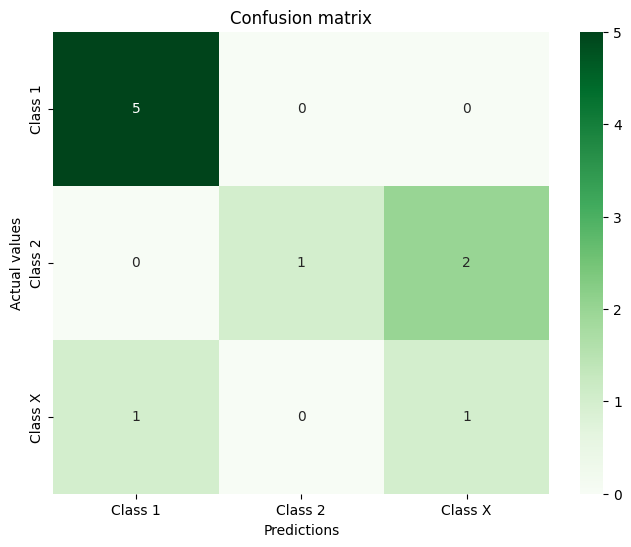

In [20]:
confusion_mat = confusion_matrix(y_test, y_pred)
# plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Class 1', 'Class 2', 'Class X'], 
            yticklabels=['Class 1', 'Class 2', 'Class X'])
plt.xlabel('Predictions')
plt.ylabel('Actual values')
plt.title('Confusion matrix')
plt.show()

The classification report is a tool that provides detailed metrics on the performance of a classification model. It is commonly used for multiclass classification problems (our case). We coul calculate each metric using the results of the confusion matrix. 

Precision: Is calculated as the number of true positives divided by the sum of true positives and false positives.

Recall: Is calculated as the number of true positives divided by the sum of true positives and false negatives.

Support: Is the total number of instances for each class in the test dataset.

Macro average: Is the mean value of each metric.

Weigthed average: Is calculated as the sum of the precision, of each class, multiply by their support and then divided by the number of instances.

In [21]:
class_report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{class_report}\n")

Classification Report:
              precision    recall  f1-score   support

           1       0.83      1.00      0.91         5
           2       1.00      0.33      0.50         3
           X       0.33      0.50      0.40         2

    accuracy                           0.70        10
   macro avg       0.72      0.61      0.60        10
weighted avg       0.78      0.70      0.68        10




And finally, the matrix of the Predictions probability. It is of dimension (number of classes X total number of instances). Each row represent  the probability of the instance belonging to a specific class. The one with the higher probability is the predicted. For example, in our table, we observe that is going to predict (1) for the first instances, (X) for the third and (2) for the fifth one.

In [22]:
predictions = rf_model.predict_proba(X_test)
print(f"Predictions probability:\n{predictions}\n")

Predictions probability:
[[7.94381893e-01 2.23684439e-02 1.83249663e-01]
 [9.82760321e-01 7.10096634e-04 1.65295825e-02]
 [8.00134536e-03 4.28970067e-01 5.63028587e-01]
 [6.78587707e-01 5.90836634e-02 2.62328629e-01]
 [3.09404856e-02 4.62822806e-01 5.06236708e-01]
 [3.62901015e-02 4.98741453e-01 4.64968446e-01]
 [9.81412868e-01 1.78946077e-03 1.67976716e-02]
 [1.38596055e-02 2.58456217e-01 7.27684178e-01]
 [7.24567082e-01 4.61110123e-02 2.29321906e-01]
 [5.51028474e-01 2.25380083e-02 4.26433518e-01]]



# Total Accuracy

In this last section, we are going to repeat the model above, but we will train all the seasons and predict all the results to estimate how it works in global. However, it is not going to be a precise analysis since the data to be predicted is going to be train before. 

In [23]:
seasons2 = "all"

In [24]:
seasons2 = parse_seasons(seasons2)
training_data2 = df_train(seasons2)
X_train2 = training_data2[features]
y_train2 = training_data2[target]

After several testing, we obtain that the best parameters to the RandomForestClassifier when we train all the seasons are:

{max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=150}

So, instead of using the GrigSearchCV function, we are going to set directly the parameters. In that way, we have reduce considerably the time of execution, from 8 minutes to 5 seconds.

On the other hand, we will the use GrigSearchCV function when the train is not of all seasons, to obtain more accurate predictions. We have selected the parameters of the paragram_grid to be similar to the ones we have obtain after training all seasons.

In [25]:
rf_model2 = RandomForestClassifier(max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=150)
rf_model2.fit(X_train2, y_train2)

RandomForestClassifier(max_depth=15, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=150)

In [26]:
test_data2 = df_train(seasons2)
X_test2 = test_data2[features]
y_test2 = test_data2[target]
y_pred2 = rf_model2.predict(X_test2)
y_pred2

array(['2', '1', '1', ..., 'X', 'X', '2'], dtype=object)

In [27]:
accuracy2 = accuracy_score(y_test2, y_pred2)
print(f"Accuracy: {accuracy2}\n")

Accuracy: 0.7418125



We observe in the confusion matrix that our model is more likely to predict (1). Actually, when the real result is a tie (X) it tends to predict (1). The predictions of the classes (2) and (X) are more accurate. In the Classification report table, we observe that the tie class (X) is the one with more precision, nearly a 90% of times it predict a tie is correct.

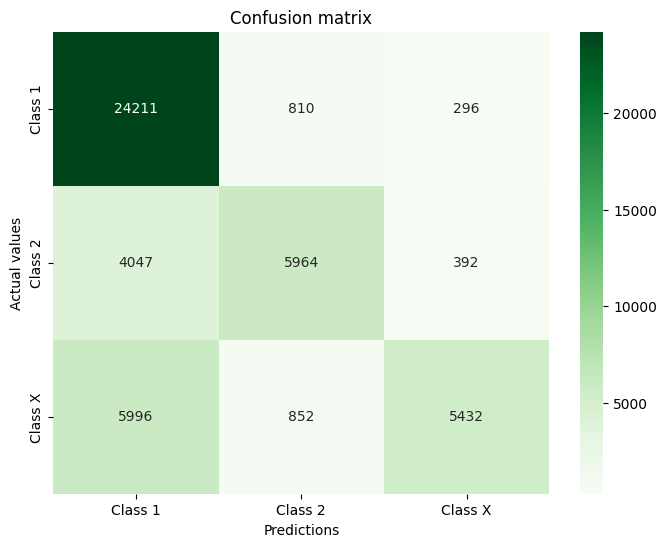

In [28]:
confusion_mat2 = confusion_matrix(y_test2, y_pred2)
confusion_mat = confusion_matrix(y_test, y_pred)
# plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat2, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Class 1', 'Class 2', 'Class X'], 
            yticklabels=['Class 1', 'Class 2', 'Class X'])
plt.xlabel('Predictions')
plt.ylabel('Actual values')
plt.title('Confusion matrix')
plt.show()

In [29]:
class_report2 = classification_report(y_test2, y_pred2)
print(f"Classification Report:\n{class_report2}\n")

Classification Report:
              precision    recall  f1-score   support

           1       0.71      0.96      0.81     25317
           2       0.78      0.57      0.66     10403
           X       0.89      0.44      0.59     12280

    accuracy                           0.74     48000
   macro avg       0.79      0.66      0.69     48000
weighted avg       0.77      0.74      0.72     48000


